# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

In [2]:
from astropy.io import ascii
data = ascii.read("R11ceph.dat")
data

col1,col2,col3,col4,col5,col6,col7
int64,int64,float64,float64,float64,float64,float64
27185,4536,24.5123,0.31,13.0,-3.46,0.13
42353,4536,25.9907,0.74,13.07,-3.03,0.37
50718,4536,24.1492,0.42,13.73,-3.36,0.28
72331,4536,24.4751,0.44,13.91,-3.19,0.22
65694,4536,24.8582,0.38,14.38,-3.1,0.39
58805,4536,22.9467,0.35,14.44,-3.22,0.26
...,...,...,...,...,...,...
307758,4258,21.7818,0.1,32.4,-3.29,-0.0
144755,4258,22.5844,0.2,12.05,-3.19,0.13


In [3]:
with open("R11ceph.dat",'r') as f:
    dat = f.read()
    print(dat)

# R11ceph.dat
#
# This is a processed version of the R11 cepheid data
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#     id: the ID of the cepheid
#    gal: the NGC number of the host galaxy
#      m: mags m are computed using m = F160W - 0.41*(V_I)
#   merr: mag errs are just those in the F160W mags
#         (errors in V-I were not given in R11)
#      P: period P is in days (errors in the Period were not given)
# logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#   bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag error is 99.0
#
#  id  gal     m       merr       P       logO_H    bias
27185 4536 24.512300 0.310000 13.000000 -3.460000 0.130000
42353 4536 25.990700 0.740000 13.070000 -3.030000 0.370000
50718 4536 24.149200 0.420000 13.730000 -3.360000 0.280000
72331 4536 24.475100 0.440000 13.910000 -3.190000 0.220000
65694 4536 24.858200 0.380000 14.380000 -3.100000 0.390000
588

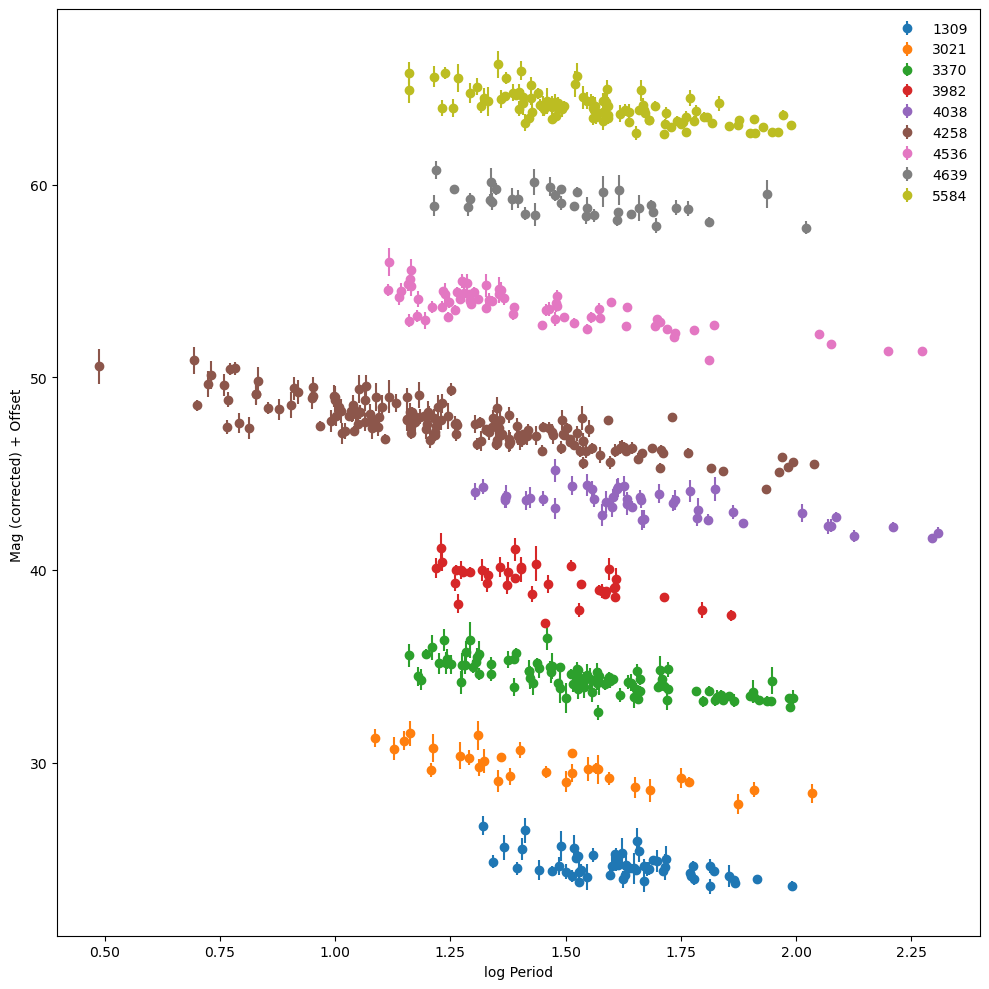

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The log of likelihood function is 

$$ ln(L) = -\frac{1}{2}\Sigma_{i,j} [\frac{(m - m_{w,i,j})^2}{\sigma_{int}^2}]$$

and $m_{w,i,j}$ is equal to

$$m_{w,i,j} = (u_{0,i}-u_{0,4258}) + zp_{w,4258} + b_{W} logP_{i,j} $$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

### Prior on $zp_{w,4258}$

In [9]:
# find the value of zpw,4258
data4258 = data[data['col2'] == 4258] #get the 4258 data
P4258 = data4258['col5']
m4258 = data4258['col3']
m, zp4258 = np.polyfit(P4258, m4258, 1)
zp4258

23.649066348238343

I have fitted the line to find the intercept of the P–L relation of the Cepheids of NGC 4258 and the results is 23.649. Thus, I am going to use this as the prior for $zp_{w,4258}$ and set a uniform distribution around this value.

### Prior on $b_{W}$

$b_{w}$ is the slope of P-L relation. As we can see from the graph above, the slope should be negative. Thus the we can take the prior to be a uniform distribution between -5 and 0. 

### Prior on $u_{0,i}-u_{0,4258}$

In [5]:
with open("R11redsh.dat",'r') as f:
    dat = f.read()
    print(dat)

# R11redsh.dat
#
# Redshifts to the Cepheid hosts in R11ceph.dat
#
# Columns:
#    gal: the NGC number of the host galaxy
#      z: redshift
#
#  gal z
1309   0.007125
3021   0.005140
3370   0.004266
3982   0.003699
4038   0.005477
4258   0.001494
4536   0.006031
4639   0.003395
5584   0.005464



From the redshift information of those galaxies, we can construct our priors of distance moduli as uniform distributions between 0 and 5. 

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [10]:
#read in data
data4536 = data[data['col2'] == 4536] #get the 4536 data
data4639 = data[data['col2'] == 4639] #get the 4639 data
data3370 = data[data['col2'] == 3370] #get the 3370 data
data3982 = data[data['col2'] == 3982] #get the 3982 data
data3021 = data[data['col2'] == 3021] #get the 3021 data
data1309 = data[data['col2'] == 1309] #get the 1309 data
data5584 = data[data['col2'] == 5584] #get the 5584 data
data4038 = data[data['col2'] == 4038] #get the 4038 data
data4258 = data[data['col2'] == 4258] #get the 4258 data

args = (data4536,data4639,data3370,data3982,data3021,data1309,data5584,data4038,data4258)


In [11]:
#function for priors

def log_prior(theta):
    u4536,u4639,u3370,u3982,u3021,u1309,u5584,u4038,bw,zp4258 = theta
    if (u4536<5) and (u4536>0) and\
    (u4639<5) and (u4639>0) and\
    (u3370<5) and (u3370>0) and\
    (u3982<5) and (u3982>0) and\
    (u3021<5) and (u3021>0) and\
    (u1309<5) and (u1309>0) and\
    (u5584<5) and (u5584>0) and\
    (u4038<5) and (u4038>0) and\
    (bw>-5) and (bw <0) and\
    (zp4258>20) and (zp4258 <30):
        return 0.0
    else:
        return -np.inf
    
def likelihood (theta,data4536,data4639,data3370,data3982,data3021,data1309,data5584,data4038,data4258):
    u4536,u4639,u3370,u3982,u3021,u1309,u5584,u4038,bw,zp4258 = theta
    log_ll = sum((np.array(data4536['col3'])-(u4536+zp4258+bw*np.log10(np.array(data4536['col5']))))**2/np.array(data4536['col4']**2))
    log_ll = log_ll + sum((np.array(data4639['col3'])-(u4639+zp4258+bw*np.log10(np.array(data4639['col5']))))**2/np.array(data4639['col4']**2))
    log_ll = log_ll + sum((np.array(data3370['col3'])-(u3370+zp4258+bw*np.log10(np.array(data3370['col5']))))**2/np.array(data3370['col4']**2))
    log_ll = log_ll + sum((np.array(data3982['col3'])-(u3982+zp4258+bw*np.log10(np.array(data3982['col5']))))**2/np.array(data3982['col4']**2))
    log_ll = log_ll + sum((np.array(data3021['col3'])-(u3021+zp4258+bw*np.log10(np.array(data3021['col5']))))**2/np.array(data3021['col4']**2))
    log_ll = log_ll + sum((np.array(data1309['col3'])-(u1309+zp4258+bw*np.log10(np.array(data1309['col5']))))**2/np.array(data1309['col4']**2))
    log_ll = log_ll + sum((np.array(data5584['col3'])-(u5584+zp4258+bw*np.log10(np.array(data5584['col5']))))**2/np.array(data5584['col4']**2))
    log_ll = log_ll + sum((np.array(data4038['col3'])-(u4038+zp4258+bw*np.log10(np.array(data4038['col5']))))**2/np.array(data4038['col4']**2))
    log_ll = log_ll + sum((np.array(data4639['col3'])-(u4639+zp4258+bw*np.log10(np.array(data4639['col5']))))**2/np.array(data4639['col4']**2))
    log_ll = log_ll + sum((np.array(data4258['col3'])-(zp4258+bw*np.log10(np.array(data4258['col5']))))**2/np.array(data4258['col4']**2))
    log_ll = -0.5*log_ll
    return log_ll

def log_posterior(theta,data4536,data4639,data3370,data3982,data3021,data1309,data5584,data4038,data4258):
    result = log_prior(theta) +likelihood (theta,data4536,data4639,data3370,data3982,data3021,data1309,data5584,data4038,data4258)
    return result

In [12]:
import emcee
ndim = 10
nwalkers = 20

nburn = 2000
nsteps = 20000

starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, 0] = np.random.uniform(0,5,20)
starting_guesses[:, 1] = np.random.uniform(0,5,20)
starting_guesses[:, 2] = np.random.uniform(0,5,20)
starting_guesses[:, 3] = np.random.uniform(0,5,20)
starting_guesses[:, 4] = np.random.uniform(0,5,20)
starting_guesses[:, 5] = np.random.uniform(0,5,20)
starting_guesses[:, 6] = np.random.uniform(0,5,20)
starting_guesses[:, 7] = np.random.uniform(0,5,20)
starting_guesses[:, 8] = np.random.uniform(-5,0,20)
starting_guesses[:, 9] = np.random.uniform(20,30,20)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=args)
_ =  sampler.run_mcmc(starting_guesses, nsteps)

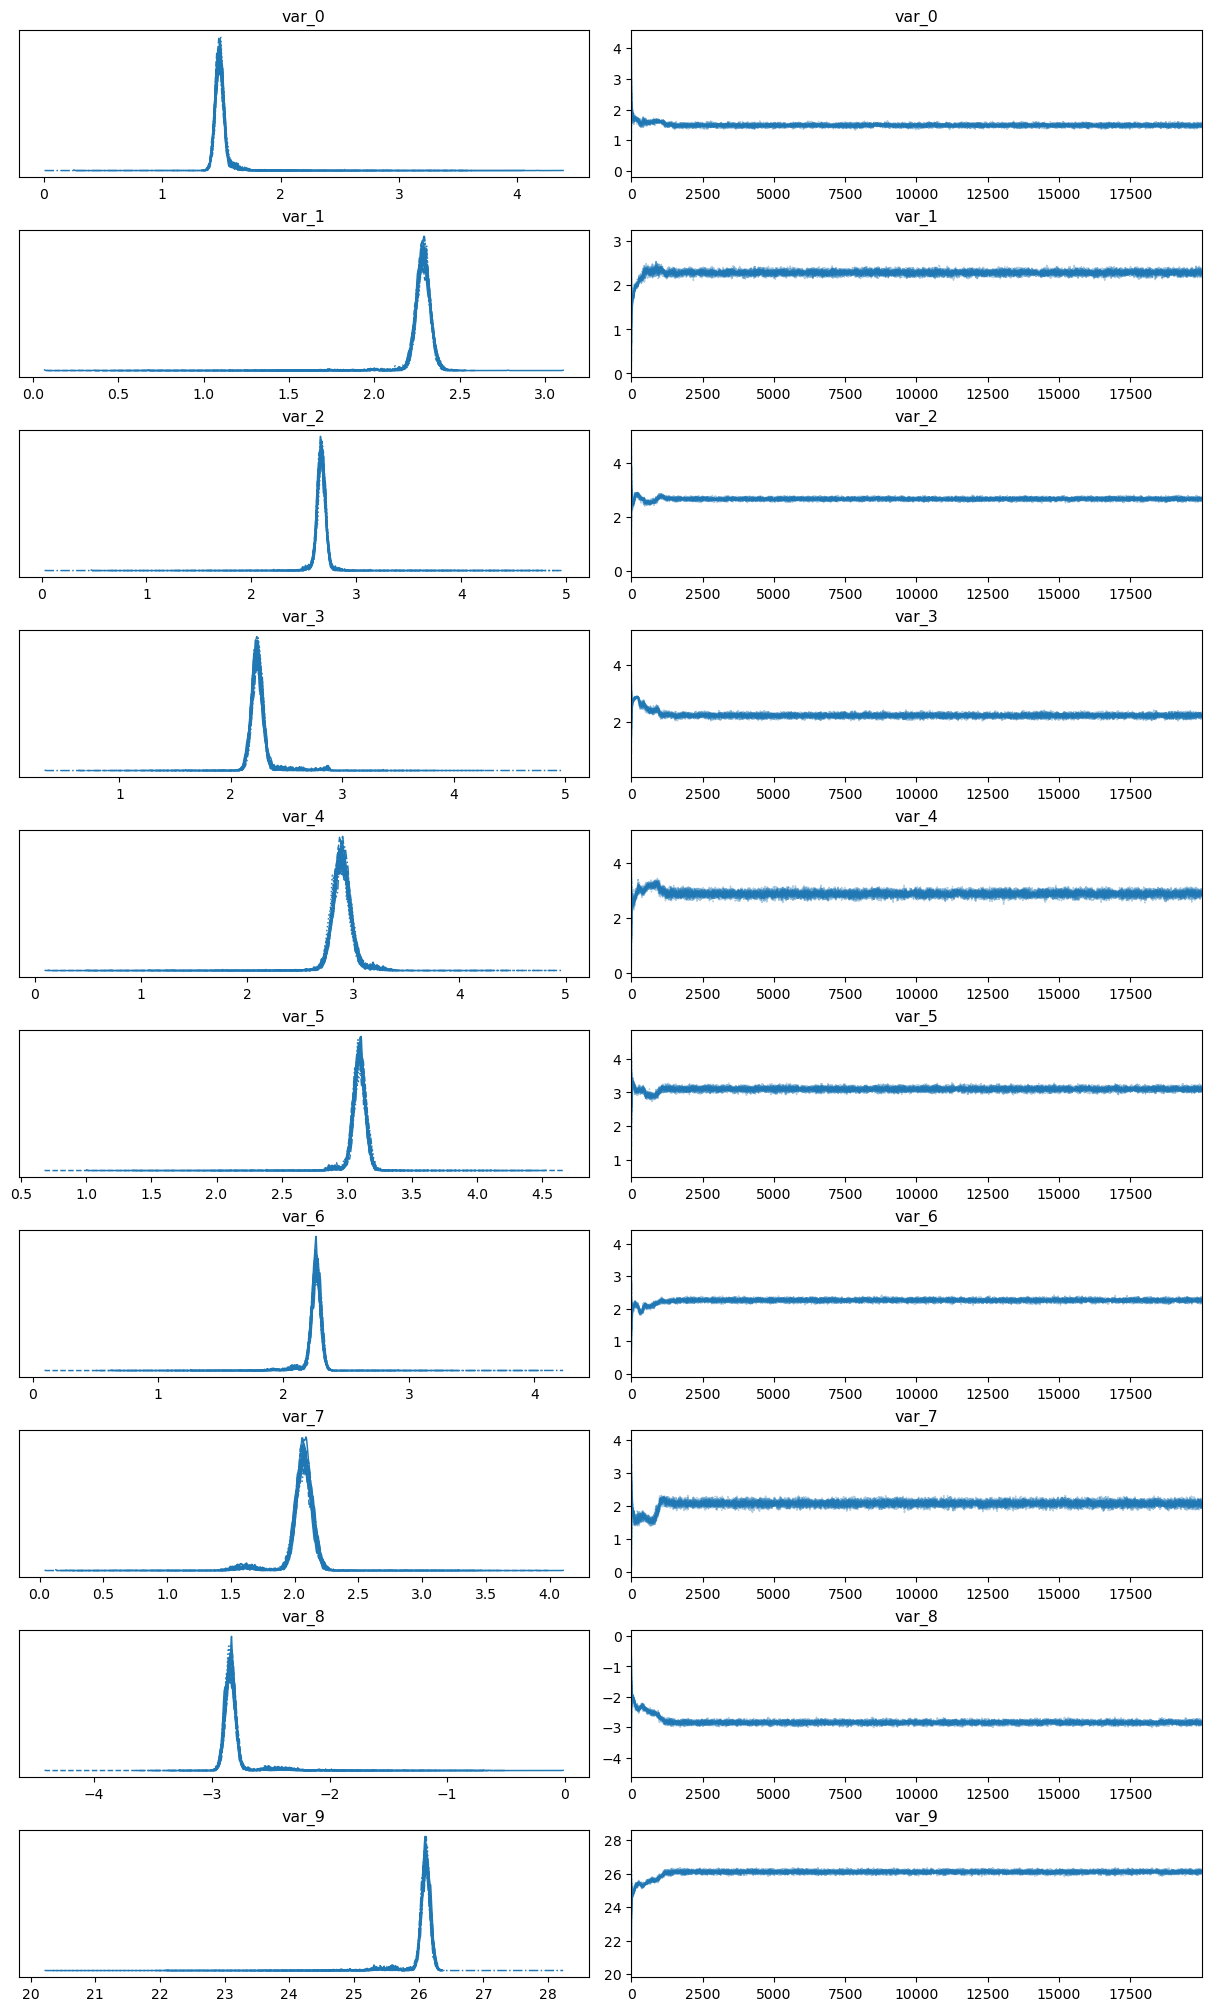

In [29]:
# plot traceplot for each parameters
import pymc3 as pm3
pm3.plot_trace(sampler)
plt.show()

In [13]:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

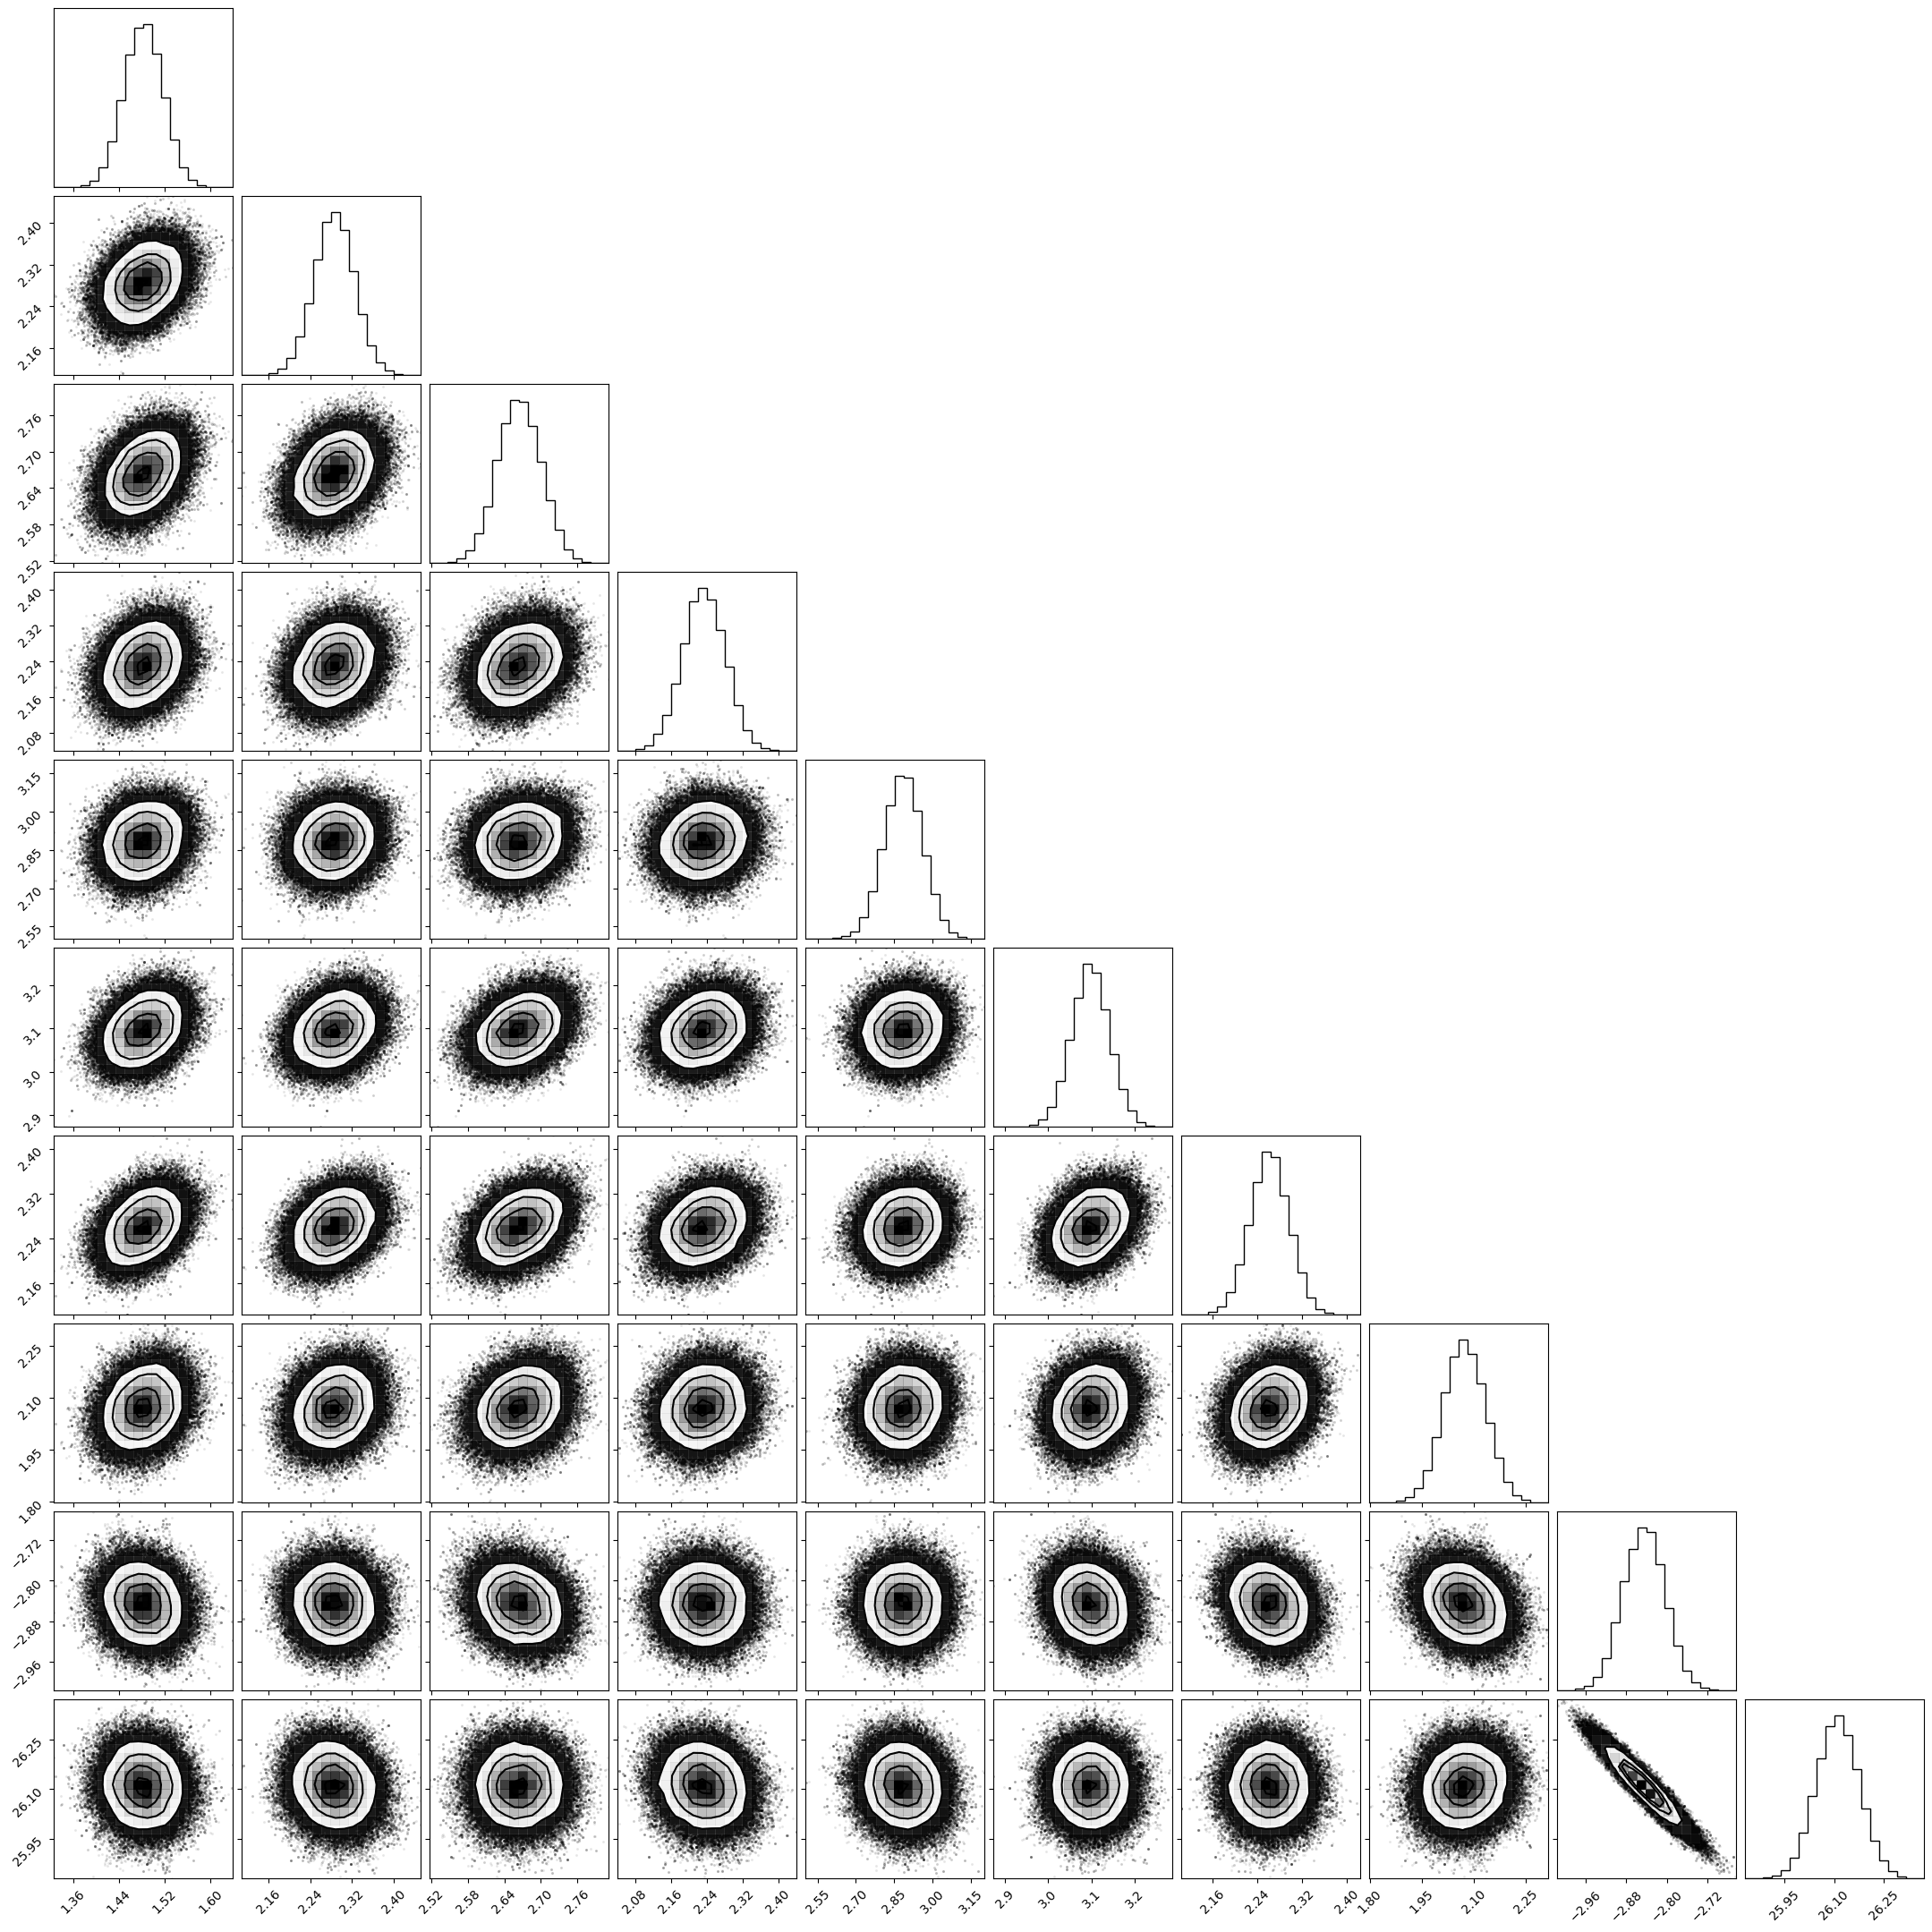

In [14]:
# plot corner plot
import corner

fig = corner.corner(
    sample
);

In [44]:
u4536_pre = np.median(sample[:,0])
u4639_pre = np.median(sample[:,1])
u3370_pre = np.median(sample[:,2])
u3982_pre = np.median(sample[:,3])
u3021_pre = np.median(sample[:,4])
u1309_pre = np.median(sample[:,5])
u5584_pre = np.median(sample[:,6])
u4038_pre = np.median(sample[:,7])
bw_pre = np.median(sample[:,8])
zp4258_pre = np.median(sample[:,9])

26.109891682075883

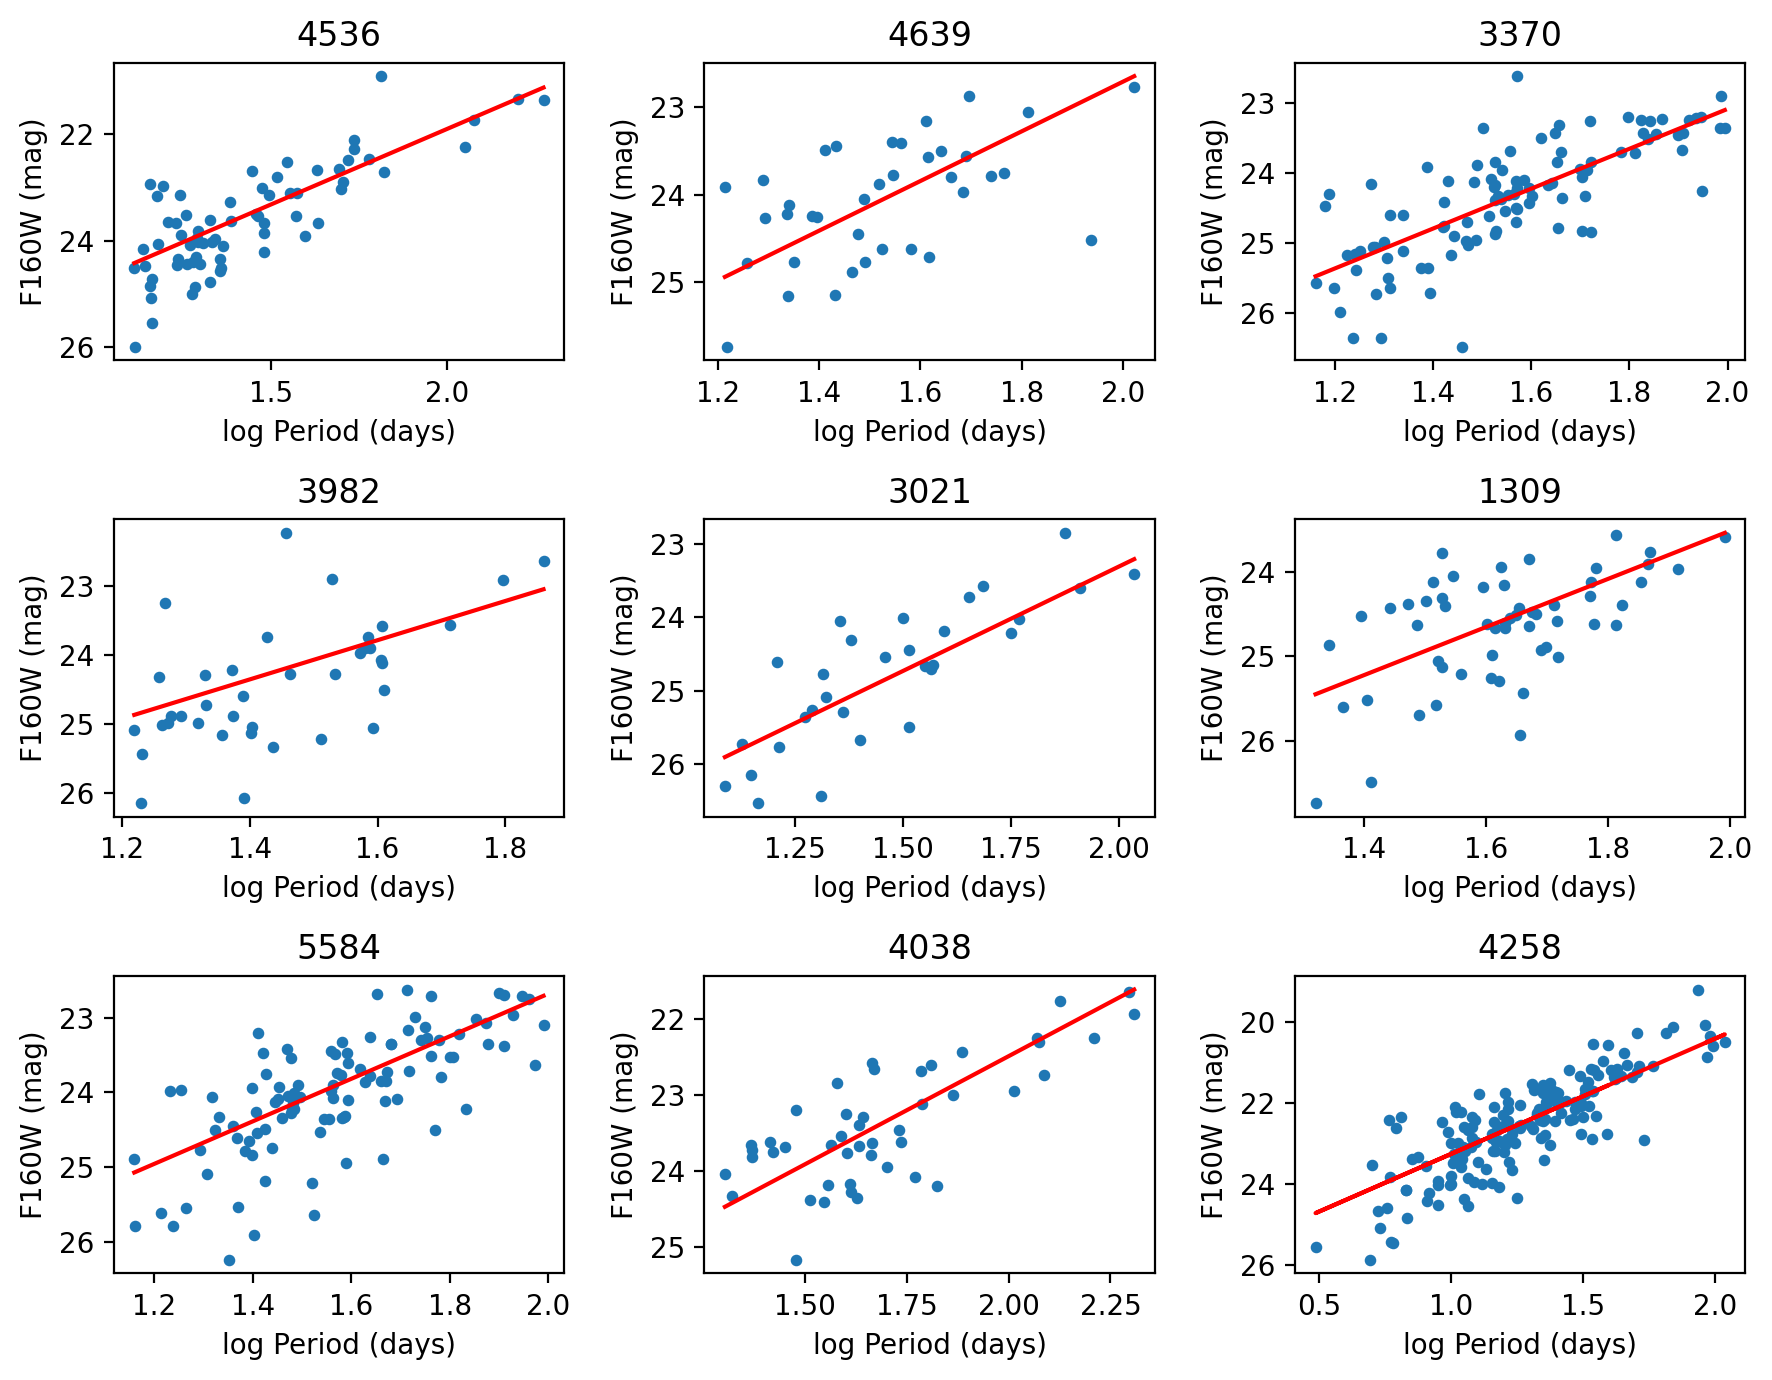

In [68]:
f = plt.figure(figsize = (9,7),dpi=200)
ax1 = f.add_subplot(331)
ax1.scatter(np.log10(np.array(data4536['col5'])),np.array(data4536['col3']),s = 10)
ax1.plot(np.log10(np.array(data4536['col5'])),u4536_pre+zp4258_pre+bw_pre*(np.log10(np.array(data4536['col5']))),color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('log Period (days)')
ax1.set_ylabel('F160W (mag)')
ax1.set_title('4536')

ax2 = f.add_subplot(332)
ax2.scatter(np.log10(np.array(data4639['col5'])),np.array(data4639['col3']),s = 10)
ax2.plot(np.log10(np.array(data4639['col5'])),u4639_pre+zp4258_pre+bw_pre*(np.log10(np.array(data4639['col5']))),color = 'red')
ax2.invert_yaxis()
ax2.set_xlabel('log Period (days)')
ax2.set_ylabel('F160W (mag)')
ax2.set_title('4639')

ax3 = f.add_subplot(333)
ax3.scatter(np.log10(np.array(data3370['col5'])),np.array(data3370['col3']),s = 10)
ax3.plot(np.log10(np.array(data3370['col5'])),u3370_pre+zp4258_pre+bw_pre*(np.log10(np.array(data3370['col5']))),color = 'red')
ax3.invert_yaxis()
ax3.set_xlabel('log Period (days)')
ax3.set_ylabel('F160W (mag)')
ax3.set_title('3370')

ax4 = f.add_subplot(334)
ax4.scatter(np.log10(np.array(data3982['col5'])),np.array(data3982['col3']),s = 10)
ax4.plot(np.log10(np.array(data3982['col5'])),u3982_pre+zp4258_pre+bw_pre*(np.log10(np.array(data3982['col5']))),color = 'red')
ax4.invert_yaxis()
ax4.set_xlabel('log Period (days)')
ax4.set_ylabel('F160W (mag)')
ax4.set_title('3982')

ax5 = f.add_subplot(335)
ax5.scatter(np.log10(np.array(data3021['col5'])),np.array(data3021['col3']),s = 10)
ax5.plot(np.log10(np.array(data3021['col5'])),u3021_pre+zp4258_pre+bw_pre*(np.log10(np.array(data3021['col5']))),color = 'red')
ax5.invert_yaxis()
ax5.set_xlabel('log Period (days)')
ax5.set_ylabel('F160W (mag)')
ax5.set_title('3021')

ax6 = f.add_subplot(336)
ax6.scatter(np.log10(np.array(data1309['col5'])),np.array(data1309['col3']),s = 10)
ax6.plot(np.log10(np.array(data1309['col5'])),u1309_pre+zp4258_pre+bw_pre*(np.log10(np.array(data1309['col5']))),color = 'red')
ax6.invert_yaxis()
ax6.set_xlabel('log Period (days)')
ax6.set_ylabel('F160W (mag)')
ax6.set_title('1309')

ax7 = f.add_subplot(337)
ax7.scatter(np.log10(np.array(data5584['col5'])),np.array(data5584['col3']),s = 10)
ax7.plot(np.log10(np.array(data5584['col5'])),u5584_pre+zp4258_pre+bw_pre*(np.log10(np.array(data5584['col5']))),color = 'red')
ax7.invert_yaxis()
ax7.set_xlabel('log Period (days)')
ax7.set_ylabel('F160W (mag)')
ax7.set_title('5584')

ax8 = f.add_subplot(338)
ax8.scatter(np.log10(np.array(data4038['col5'])),np.array(data4038['col3']),s = 10)
ax8.plot(np.log10(np.array(data4038['col5'])),u4038_pre+zp4258_pre+bw_pre*(np.log10(np.array(data4038['col5']))),color = 'red')
ax8.invert_yaxis()
ax8.set_xlabel('log Period (days)')
ax8.set_ylabel('F160W (mag)')
ax8.set_title('4038')

ax9 = f.add_subplot(339)
ax9.scatter(np.log10(np.array(data4258['col5'])),np.array(data4258['col3']),s = 10)
ax9.plot(np.log10(np.array(data4258['col5'])),zp4258_pre+bw_pre*(np.log10(np.array(data4258['col5']))),color = 'red')
ax9.invert_yaxis()
ax9.set_xlabel('log Period (days)')
ax9.set_ylabel('F160W (mag)')
ax9.set_title('4258')

plt.tight_layout()

In [67]:
#compare the intercept

print('for n4536,the predicted intercept is:', u4536_pre, ',and the paper value is:', 1.567)
print('for n4639,the predicted intercept is:', u4639_pre, ',and the paper value is:', 2.383)
print('for n3370,the predicted intercept is:', u3370_pre, ',and the paper value is:', 2.835)
print('for n3982,the predicted intercept is:', u3982_pre, ',and the paper value is:', 2.475)
print('for n3021,the predicted intercept is:', u3021_pre, ',and the paper value is:', 3.138)
print('for n1309,the predicted intercept is:', u1309_pre, ',and the paper value is:', 3.276)
print('for n5584,the predicted intercept is:', u5584_pre, ',and the paper value is:', 2.461)
print('for n4038,the predicted intercept is:', u4038_pre, ',and the paper value is:', 2.396)

print ('The fits are pretty good')

for n4536,the predicted intercept is: 1.4824279862940912 ,and the paper value is: 1.567
for n4639,the predicted intercept is: 2.2859609318878635 ,and the paper value is: 2.383
for n3370,the predicted intercept is: 2.6642110044687732 ,and the paper value is: 2.835
for n3982,the predicted intercept is: 2.233386135890691 ,and the paper value is: 2.475
for n3021,the predicted intercept is: 2.884954416209416 ,and the paper value is: 3.138
for n1309,the predicted intercept is: 3.0971812329716646 ,and the paper value is: 3.276
for n5584,the predicted intercept is: 2.2613222093277265 ,and the paper value is: 2.461
for n4038,the predicted intercept is: 2.0725369547885024 ,and the paper value is: 2.396
the fits are pretty good


# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

The equation 3 in the paper is:
$$m^{0}_{v,i} = ( u_{0,i}-u_{0,4258}) + m^{0}_{v,4258}$$

Thus we know
$$m^{0}_{v,4258} = m^{0}_{v,i} - ( u_{0,i}-u_{0,4258}) $$

And equation 4 is:
$$ log H_{0} = \frac {(m^{0}_{v,4258}-u_{0,4258})+5a_{v}+25}{5} $$

By substitution

$$ log H_{0} = \frac {(m^{0}_{v,i} - ( u_{0,i}-u_{0,4258})-u_{0,4258})+5a_{v}+25}{5} $$

$$ log H_{0} = \frac {(m^{0}_{v,i}+5a_{v}) - ( u_{0,i}-u_{0,4258})-u_{0,4258}+25}{5} $$



# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [82]:
data_sn = [15.147,16.040,16.545,15.953,16.699,16.768,16.274,15.901]
data_sn = np.array(data_sn)
dis_mo = [u4536_pre,u4639_pre,u3370_pre,u3982_pre,u3021_pre,u1309_pre,u5584_pre,u4038_pre]
dis_mo = np.array(dis_mo)

In [83]:
#from the paper we know the distance to NGC4258
u = 5*np.log10(7600000)-5

In [84]:
logh0 = (data_sn-dis_mo-u+25)/5

In [95]:
h0_est = np.median(10**(logh0))
h0_est

75.16857671181435

$H_{0}$ estimate is : 75.16857671181435 $kms^{−1}Mpc^{−1}$'